In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
%matplotlib inline

In [3]:
data = pd.read_csv('/home/manikanta/Documents/ML/K-Mean/minute_weather.csv')

In [4]:
data.shape

(1587257, 13)

In [5]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


# Data Sampling

In [6]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

#  Statistics

In [7]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937510,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [8]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [9]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

#  Drop all the Rows with Empty rain_duration and rain_accumulation

In [10]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [11]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

In [12]:
# How many rows did we drop ?
rows_before - rows_after


46

In [13]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

In [14]:
# Select Features of Interest for Clustering
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [15]:
select_df = sampled_df[features]

In [16]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [17]:
select_df

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4
...,...,...,...,...,...,...,...
1587210,915.9,75.56,330.0,1.0,341.0,1.3,47.8
1587220,915.9,75.56,330.0,1.1,341.0,1.4,48.0
1587230,915.9,75.56,344.0,1.4,352.0,1.7,48.0
1587240,915.9,75.20,359.0,1.3,9.0,1.6,46.3


In [18]:
# Scale the Features using StandardScale
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

In [19]:
# Use k-Means Clustering
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(n_clusters=12)


In [20]:
# Cluster center formed
centers = model.cluster_centers_
centers

array([[ 0.24628046,  0.32729772,  1.88885446, -0.64943748, -1.55191428,
        -0.57420599, -0.29361798],
       [ 1.38770484, -0.06651265, -1.14781033, -0.09362251, -1.00834624,
        -0.07342055, -0.99782472],
       [-0.88659314, -0.62903912,  0.21112561, -0.58198293,  0.35346069,
        -0.58273953,  1.04071576],
       [ 0.16041186, -0.79899678, -1.2244478 , -0.5541262 , -1.07789682,
        -0.56993399,  0.85383625],
       [-1.23824514, -0.80712255,  0.45073885,  2.03778708,  0.54073415,
         1.99680758,  0.85241619],
       [ 1.18772827, -0.25216685, -1.15410609,  2.09691723, -1.05206887,
         2.21331501, -1.13226108],
       [-0.03084891,  0.68143376,  0.22371345, -0.62589133,  0.40261659,
        -0.63841254, -0.54525147],
       [-0.1998865 ,  0.84872635, -1.30171558, -0.58566049, -1.15999992,
        -0.60173589, -0.61403471],
       [ 0.60107833, -1.00106497,  0.80488244, -0.47878343,  1.0108694 ,
        -0.45174713,  0.97929349],
       [-0.21830315,  0.6175

In [21]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [22]:
# Function that creates Parallel Plots

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [23]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.246280,0.327298,1.888854,-0.649437,-1.551914,-0.574206,-0.293618,0
1,1.387705,-0.066513,-1.147810,-0.093623,-1.008346,-0.073421,-0.997825,1
2,-0.886593,-0.629039,0.211126,-0.581983,0.353461,-0.582740,1.040716,2
3,0.160412,-0.798997,-1.224448,-0.554126,-1.077897,-0.569934,0.853836,3
4,-1.238245,-0.807123,0.450739,2.037787,0.540734,1.996808,0.852416,4
5,1.187728,-0.252167,-1.154106,2.096917,-1.052069,2.213315,-1.132261,5
6,-0.030849,0.681434,0.223713,-0.625891,0.402617,-0.638413,-0.545251,6
7,-0.199886,0.848726,-1.301716,-0.585660,-1.160000,-0.601736,-0.614035,7
8,0.601078,-1.001065,0.804882,-0.478783,1.010869,-0.451747,0.979293,8
9,-0.218303,0.617597,0.402451,0.663863,0.511160,0.605241,-0.171972,9


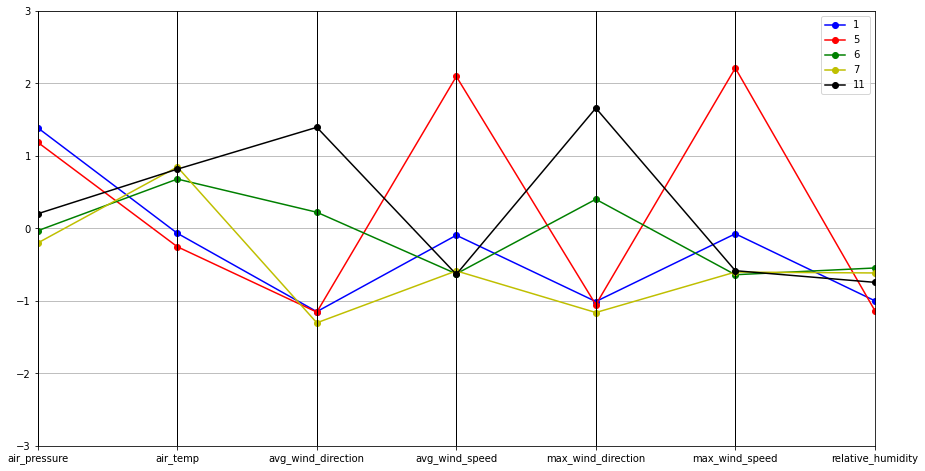

In [24]:
# Dry Days
parallel_plot(P[P['relative_humidity'] < -0.5])

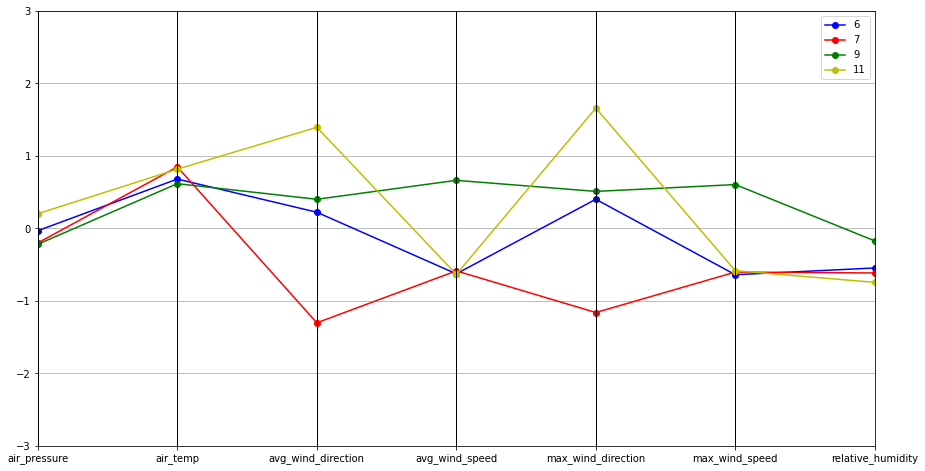

In [25]:
# Warm Days
parallel_plot(P[P['air_temp'] > 0.5])

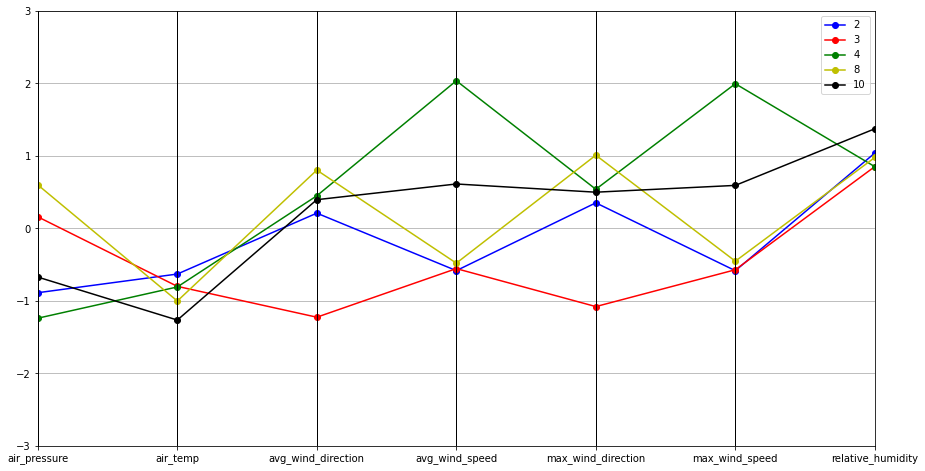

In [26]:
# Cool Days
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])